# Transfer Learning with Tensorflow : Scaling up

In [1]:
# Install TensorFlow 2.9.0 to avoid issues (later versions may work)
# -U stands for "update" and "-q" stands for "quiet"
# import tensorflow as tf
# if tf.__version__ != "2.9.0":
#   !pip install -U -q tensorflow==2.9.0
#   !pip install -q tensorflow_datasets==4.8.2
#   !pip install -q protobuf==3.19.6
#   !pip install -q tensorflow_metadata==1.12.0
#   # import os
#   # os._exit(00)
# print(tf.__version__)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import mixed_precision
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
mixed_precision.set_global_policy('mixed_float16')

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
2.14.0-dev20230706
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [2]:
# import helper functions
if "helper_functions.py" not in os.listdir("."):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

In [3]:
# Download Food101 data -> 10% data
import os
if "101_food_classes_10_percent.zip" not in os.listdir("."):
  !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
  unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [4]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_quesadilla'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/seaweed_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/risotto'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_fo

In [5]:
# Set up data inputs
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=(224,224),
                                                                 batch_size=32,
                                                                 shuffle=True)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(224,224),
                                                                batch_size=32,
                                                                shuffle=False)  #Dont shuffle for prediction and analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a model with transfer learning with 10% of Food101 data
* Create ModelCheckpoint callback
* Create a data augmentation layer
* Build a headless(no top layers) Functional EfficientNetB0 backboned-model
* Compile model
* Feature extract for 5 epochs

In [6]:
# Create callback:
checkpoint_path = "101_food_checkpoint/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         safe_freq="epoch",
                                                         monitor="accuracy")

In [7]:
# Create data augmentation layer:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
],name="data_augmentation")

In [8]:
#Setup the base model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

inputs = tf.keras.layers.Input(shape=(224,224,3))
x = data_augmentation(inputs,training=True)
x = base_model(x,training=False) # weights which need to stay frozen will stay frozen -> Inference mode
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(train_data.class_names),activation=tf.keras.activations.softmax,dtype=tf.float32)(x)
model = tf.keras.Model(inputs,outputs)

In [9]:
# GEt summary of model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                             

In [10]:
#Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

#Run feature extraction for 5 epochs
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks=[checkpoint_callback])

Epoch 1/5


237/237 [==============================] - 164s 679ms/step - loss: 3.3757 - accuracy: 0.2787 - val_loss: 2.6235 - val_accuracy: 0.4192
Epoch 2/5
237/237 [==============================] - 129s 543ms/step - loss: 2.1957 - accuracy: 0.4972 - val_loss: 2.1998 - val_accuracy: 0.4695
Epoch 3/5
237/237 [==============================] - 107s 452ms/step - loss: 1.8158 - accuracy: 0.5634 - val_loss: 2.1094 - val_accuracy: 0.4730
Epoch 4/5
237/237 [==============================] - 98s 414ms/step - loss: 1.6064 - accuracy: 0.6110 - val_loss: 2.0304 - val_accuracy: 0.4889
Epoch 5/5
237/237 [==============================] - 91s 385ms/step - loss: 1.4544 - accuracy: 0.6444 - val_loss: 1.9851 - val_accuracy: 0.4955


In [11]:
# Evaluate on full data
result = model.evaluate(test_data)
result

790/790 [==============================] - 169s 213ms/step - loss: 1.7719 - accuracy: 0.5454


[1.771885633468628, 0.5453861355781555]

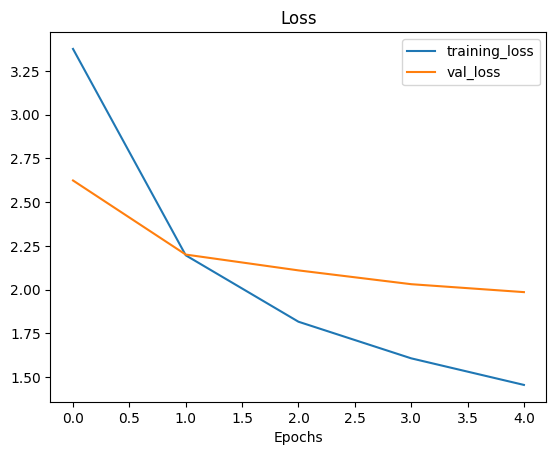

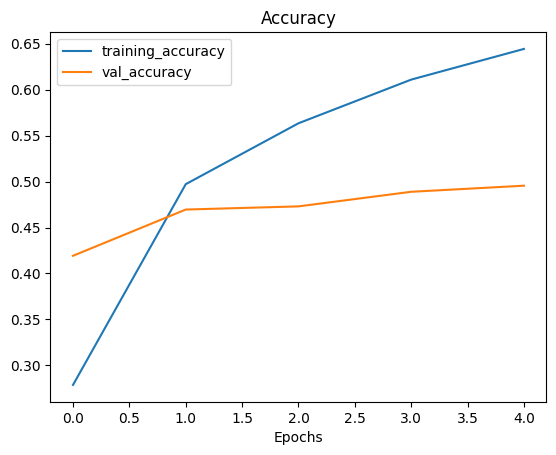

In [12]:
plot_loss_curves(history)

In [13]:
#Fine tune
base_model.trainable=True

for layer in base_model.layers[:-5]:
  layer.trainable=False

In [14]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
history1=model.fit(train_data,
                   epochs=10,
                   validation_data=test_data,
                   validation_steps=int(0.15*len(test_data)),
                   steps_per_epoch=len(train_data),
                   initial_epoch=history.epoch[-1])

Epoch 5/10


237/237 [==============================] - 69s 275ms/step - loss: 1.2084 - accuracy: 0.6807 - val_loss: 1.9435 - val_accuracy: 0.5037
Epoch 6/10
237/237 [==============================] - 65s 275ms/step - loss: 1.0980 - accuracy: 0.7061 - val_loss: 1.9353 - val_accuracy: 0.5061
Epoch 7/10
237/237 [==============================] - 60s 252ms/step - loss: 1.0121 - accuracy: 0.7284 - val_loss: 1.9117 - val_accuracy: 0.5130
Epoch 8/10
237/237 [==============================] - 59s 247ms/step - loss: 0.9609 - accuracy: 0.7405 - val_loss: 1.8889 - val_accuracy: 0.5169
Epoch 9/10
237/237 [==============================] - 53s 223ms/step - loss: 0.8661 - accuracy: 0.7666 - val_loss: 1.9261 - val_accuracy: 0.5127
Epoch 10/10
237/237 [==============================] - 52s 219ms/step - loss: 0.8409 - accuracy: 0.7747 - val_loss: 1.8568 - val_accuracy: 0.5222


In [15]:
# Evaluate
result1 = model.evaluate(test_data)
result1

  1/790 [..............................] - ETA: 1:02 - loss: 2.9673 - accuracy: 0.2188

790/790 [==============================] - 103s 130ms/step - loss: 1.6620 - accuracy: 0.5725


[1.6620210409164429, 0.5725148320198059]

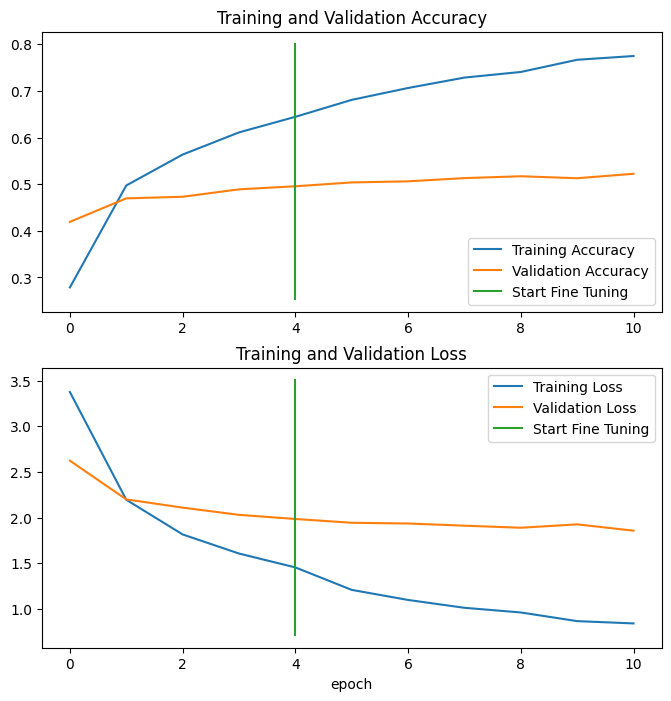

In [16]:
compare_historys(history,history1)

The model is overfitting even after fine tuning

In [17]:
# Saving and loading our model -> to use our model for external applications
model.save("tensorflow_course/101_food_classes_10_percent_model")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8ca6621f10>, 140243574729296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8ca6621f10>, 140243574729296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8ca6657550>, 140243574872624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8ca6657550>, 140243574872624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8cac0d8400>, 140243574729296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8cac0d8400>, 140243574729296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8ca656baf0>, 140243574872624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8ca656baf0>, 140243574872624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8ca6621f10>, 140243574729296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8ca6621f10>, 140243574729296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8ca6657550>, 140243574872624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8ca6657550>, 140243574872624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8cac0d8400>, 140243574729296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 320), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8cac0d8400>, 140243574729296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8ca656baf0>, 140243574872624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 320, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f8ca656baf0>, 140243574872624), {}).


INFO:tensorflow:Assets written to: tensorflow_course/101_food_classes_10_percent_model/assets


INFO:tensorflow:Assets written to: tensorflow_course/101_food_classes_10_percent_model/assets


In [18]:
#Load the entire model
loaded_model = tf.keras.models.load_model("tensorflow_course/101_food_classes_10_percent_model")

In [19]:
# Evaluate the loaded model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 92s 116ms/step - loss: 1.6577 - accuracy: 0.5733


[1.657699704170227, 0.5733069181442261]

In [20]:
result1

[1.6620210409164429, 0.5725148320198059]

### Evaluating the performance of the model across all different classes

In [21]:
## Download the pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

/bin/bash: /home/ujjwal/miniconda3/envs/tf-nightly/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-08-22 23:29:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4007:828::2010, 2404:6800:4007:829::2010, 2404:6800:4007:82a::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4007:828::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’

06_101_food_class_1 100%[===================>]  44.59M  14.1MB/s    in 3.9s    

2023-08-22 23:29:12 (11.4 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip.1’ saved [46760742/46760742]



In [22]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [23]:
#Load in the downloaded model
model_1 = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")
model_1.summary()

Model: "functional_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, None, None, 3)     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d_9  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 41

In [24]:
# Evaluate the loaded model
results = model_1.evaluate(test_data)
results

790/790 [==============================] - 64s 79ms/step - loss: 1.8027 - accuracy: 0.6078


[1.802719235420227, 0.6077623963356018]

In [25]:
## Make predictions with trained model
preds_probs = model_1.predict(test_data,verbose=1)

790/790 [==============================] - 62s 77ms/step


In [26]:
len(preds_probs)

25250

In [27]:
preds_probs.shape

(25250, 101)

In [28]:
len(test_data)

790

In [29]:
# Let us see first 10 predictions
preds_probs[:10]

array([[5.9541825e-02, 3.5742466e-06, 4.1376930e-02, ..., 1.4138791e-09,
        8.3531413e-05, 3.0897828e-03],
       [9.6401709e-01, 1.3753224e-09, 8.4778789e-04, ..., 5.4285512e-05,
        7.8361944e-12, 9.8465125e-10],
       [9.5925927e-01, 3.2533975e-05, 1.4866843e-03, ..., 7.1888911e-07,
        5.4399840e-07, 4.0275489e-05],
       ...,
       [4.7313052e-01, 1.2931325e-07, 1.4805570e-03, ..., 5.9749949e-04,
        6.6969180e-05, 2.3469596e-05],
       [4.4571884e-02, 4.7265820e-07, 1.2258432e-01, ..., 6.3498178e-06,
        7.5319422e-06, 3.6778981e-03],
       [7.2438639e-01, 1.9249942e-09, 5.2311203e-05, ..., 1.2291506e-03,
        1.5792976e-09, 9.6396325e-05]], dtype=float32)

In [30]:
# First predicition
preds_probs[0]

array([5.9541825e-02, 3.5742466e-06, 4.1376930e-02, 1.0660659e-09,
       8.1614457e-09, 8.6640339e-09, 8.0927686e-07, 8.5652601e-07,
       1.9859266e-05, 8.0978015e-07, 3.1727994e-09, 9.8673945e-07,
       2.8532426e-04, 7.8049511e-10, 7.4230711e-04, 3.8916540e-05,
       6.4741130e-06, 2.4977644e-06, 3.7890746e-05, 2.0678411e-07,
       1.5538501e-05, 8.1507983e-07, 2.6230423e-06, 2.0010653e-07,
       8.3827877e-07, 5.4216357e-06, 3.7391112e-06, 1.3150536e-08,
       2.7761478e-03, 2.8052085e-05, 6.8562828e-10, 2.5574815e-05,
       1.6688996e-04, 7.6407897e-10, 4.0453294e-04, 1.3150738e-08,
       1.7957605e-06, 1.4448289e-06, 2.3062764e-02, 8.2467824e-07,
       8.5365559e-07, 1.7138567e-06, 7.0525593e-06, 1.8402206e-08,
       2.8553276e-07, 7.9484689e-06, 2.0681657e-06, 1.8525297e-07,
       3.3620097e-08, 3.1522458e-04, 1.0410945e-05, 8.5447977e-07,
       8.4741890e-01, 1.0555468e-05, 4.4094386e-07, 3.7404119e-05,
       3.5306271e-05, 3.2489141e-05, 6.7314890e-05, 1.2852571e

In [31]:
len(preds_probs[0])

101

In [32]:
# We get one pred prob per class
print("Number of prediction probabilities for first sample :",len(preds_probs[0]))
print("What prediciton probability of first sample looks like :\n",preds_probs[0])
print("The class with the highest prediction probabilty by the model for first sample :",tf.argmax(preds_probs[0]).numpy())

Number of prediction probabilities for first sample : 101
What prediciton probability of first sample looks like :
 [5.9541825e-02 3.5742466e-06 4.1376930e-02 1.0660659e-09 8.1614457e-09
 8.6640339e-09 8.0927686e-07 8.5652601e-07 1.9859266e-05 8.0978015e-07
 3.1727994e-09 9.8673945e-07 2.8532426e-04 7.8049511e-10 7.4230711e-04
 3.8916540e-05 6.4741130e-06 2.4977644e-06 3.7890746e-05 2.0678411e-07
 1.5538501e-05 8.1507983e-07 2.6230423e-06 2.0010653e-07 8.3827877e-07
 5.4216357e-06 3.7391112e-06 1.3150536e-08 2.7761478e-03 2.8052085e-05
 6.8562828e-10 2.5574815e-05 1.6688996e-04 7.6407897e-10 4.0453294e-04
 1.3150738e-08 1.7957605e-06 1.4448289e-06 2.3062764e-02 8.2467824e-07
 8.5365559e-07 1.7138567e-06 7.0525593e-06 1.8402206e-08 2.8553276e-07
 7.9484689e-06 2.0681657e-06 1.8525297e-07 3.3620097e-08 3.1522458e-04
 1.0410945e-05 8.5447977e-07 8.4741890e-01 1.0555468e-05 4.4094386e-07
 3.7404119e-05 3.5306271e-05 3.2489141e-05 6.7314890e-05 1.2852571e-08
 2.6219715e-10 1.0318171e-05 8.5

In [33]:
test_data.class_names[52]

'gyoza'

In [34]:
# Get pred classes of each label
pred_classes = tf.argmax(preds_probs,axis=1).numpy()
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [35]:
len(pred_classes)

25250

In [36]:
# Compare the predictions with actual class
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [37]:
# To get test_labels -> unravel test_data
y_labels = []
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [38]:
len(y_labels)

25250

we kept shuffle=False in beginning, hence the order in preds_prods and y_labels are in same order, so comparining them is easier now

In [39]:
# Let us try scikin learn accuracy score function
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels,pred_classes)
sklearn_accuracy

0.6077623762376237

In [40]:
results

[1.802719235420227, 0.6077623963356018]

In [41]:
import numpy as np
np.isclose(results[1],sklearn_accuracy)

True

### Making confusion matrix

In [42]:
from helper_functions import make_confusion_matrix

In [43]:
make_confusion_matrix(y_labels,
                      pred_classes,
                      classes=test_data.class_names,
                      figsize=(120,120),
                      text_size=40)

### Classification report
for each class

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_labels,
                            pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of the model's predictions but with so may classes, they are quite hard to understand
* Create visulization for better understanding


In [45]:
# Get a dictionary of classification report
classification_report_dict = classification_report(y_labels,
                                                   pred_classes,
                                                   output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250.0},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250.0},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250.0},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250.0},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'sup

let's plot f1 scores of classes

In [46]:
class_f1_scores={}
for key,val in classification_report_dict.items():
  if key=="accuracy":
    break
  else:
    class_f1_scores[test_data.class_names[int(key)]] = val["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [47]:
# Turn f1 scores in dataframes
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

In [48]:
f1_scores

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
56     huevos_rancheros  0.339833
22     chocolate_mousse  0.329159
77            pork_chop  0.308756
39            foie_gras  0.297491
0             apple_pie  0.240566

[101 rows x 2 columns]

In [49]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

In [50]:
f1_scores[:-10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
..                  ...       ...
5            beet_salad  0.418605
87             scallops  0.397541
37         filet_mignon  0.387006
8         bread_pudding  0.386694
98             tiramisu  0.385882

[91 rows x 2 columns]

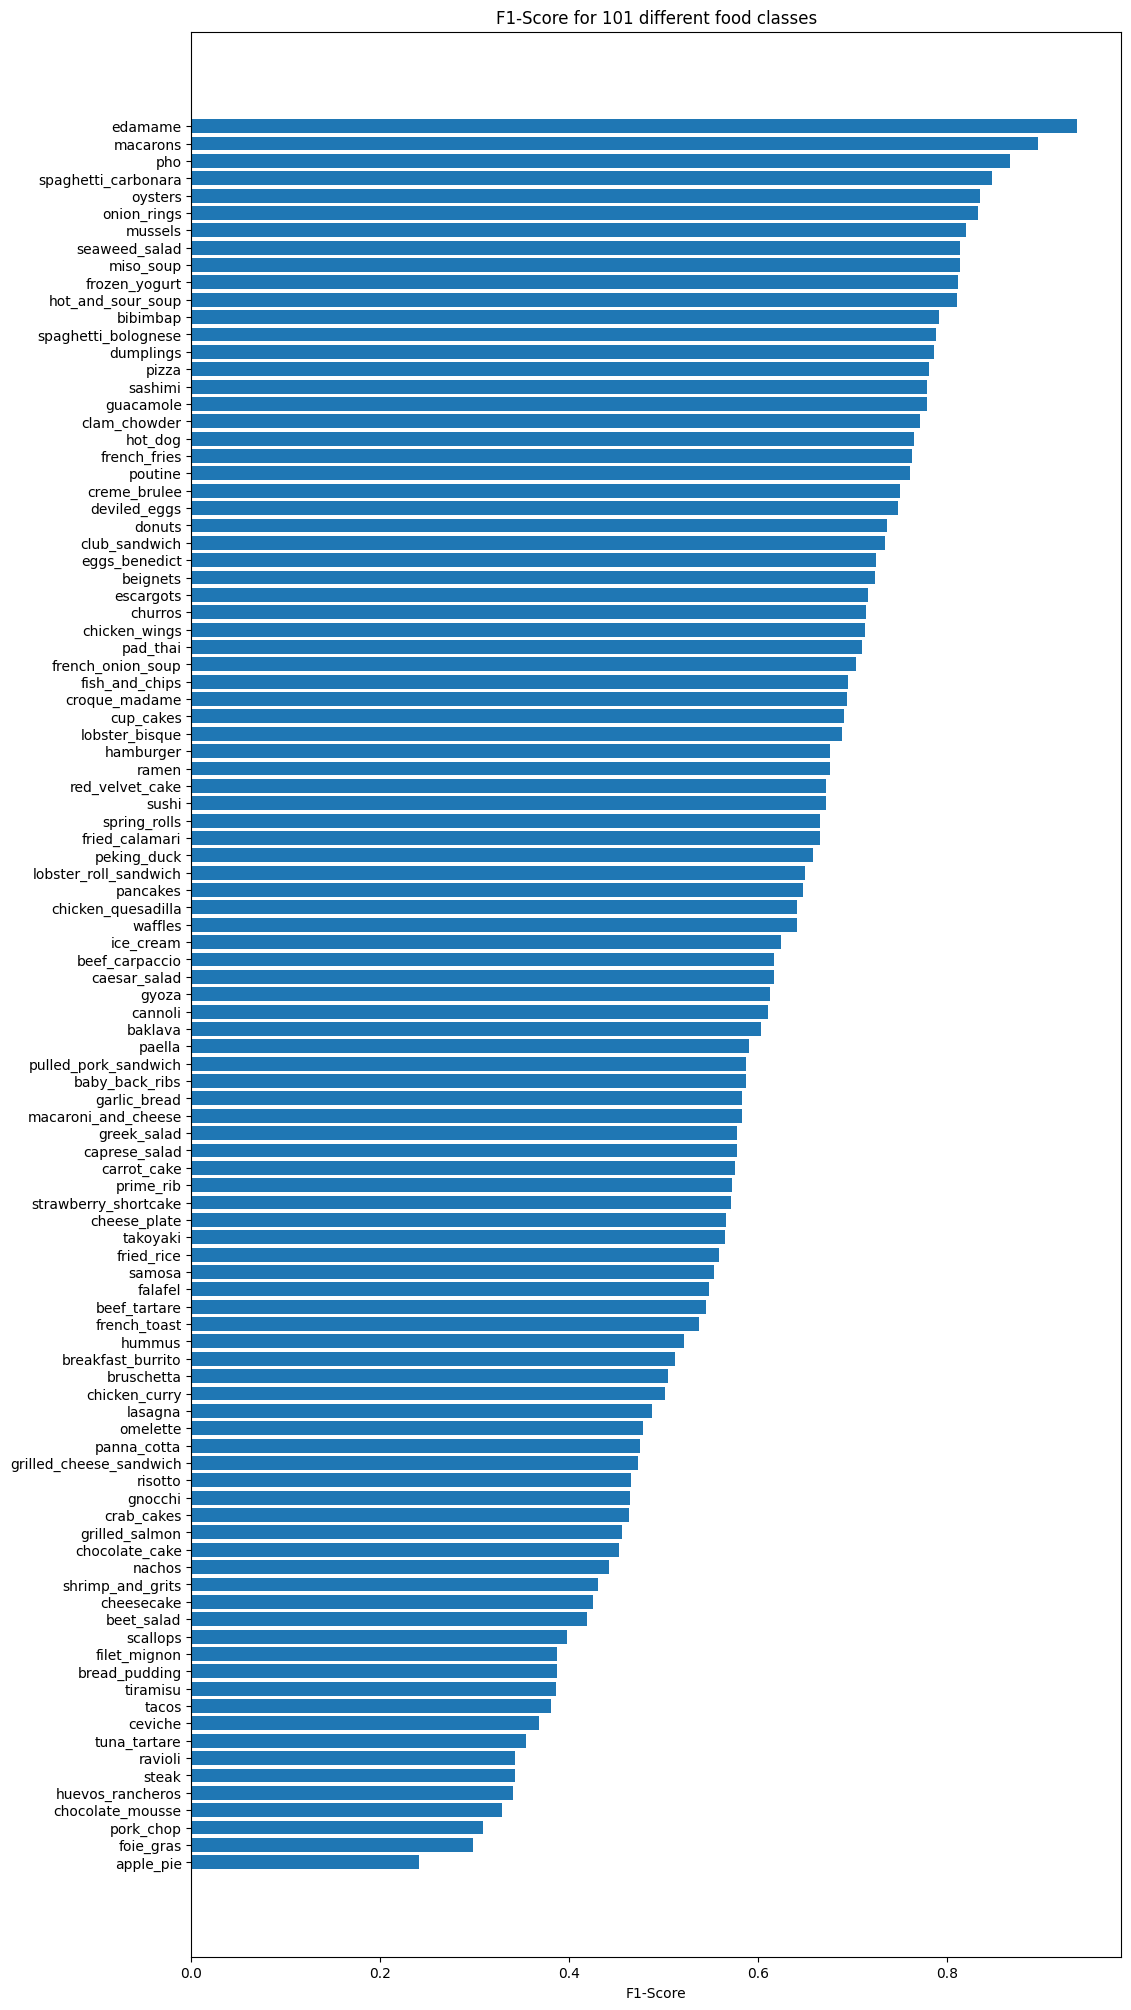

In [51]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)),f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-Score")
ax.set_title("F1-Score for 101 different food classes")
ax.invert_yaxis()
plt.show()

### Visualise predictions on test images

Functions to load and preprocess the loaded image and use custom image
* Read in a target image filepath using tf.io.read_file()
* Turn the image into a tensor using tf.io.decode_image()
* Resize the image tensor
* Scale the image to get all the pixel values between 0 and 1 (if necessary)

In [52]:
# Create a function to lead and prepare images
def load_and_prep(filename,img_shape=224,scale=True):
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

Now let's write some code to:

1. Load a few random images from the test dataset.
2. Make predictions on them.
3. Plot the original image(s) along with the model's predicted label, prediction probability and ground truth label.

1/1 [==============================] - 0s 188ms/step


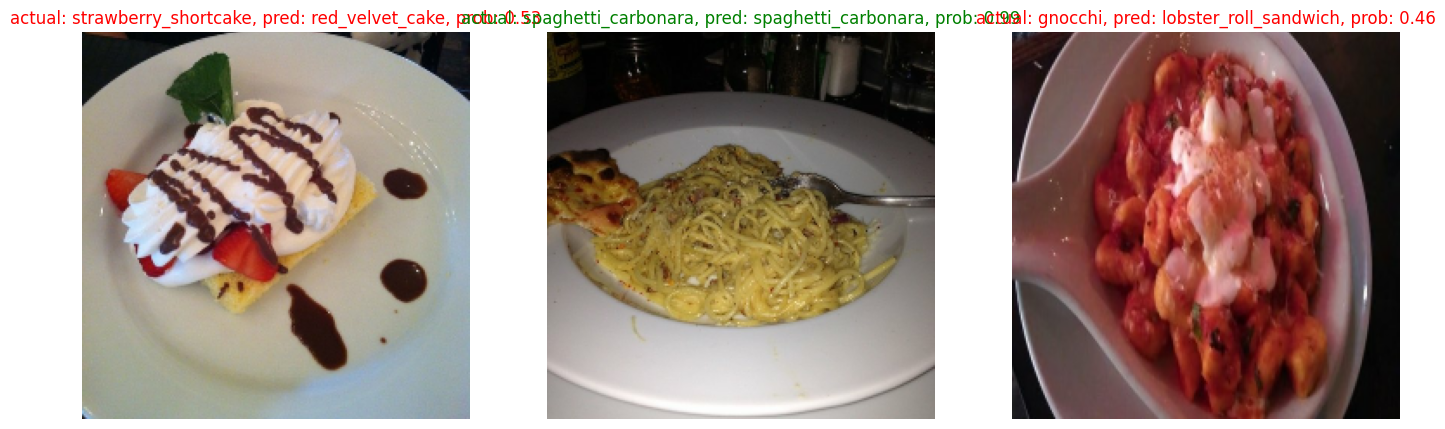

In [53]:
# Make preds on series of random images
import os
import random

class_names=test_data.class_names

plt.figure(figsize=(17,10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

### Finding the most wrong prediction

We'll go through the following steps:

1. Get all of the image file paths in the test dataset using the list_files() method.
2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
5. Visualize the images with the highest prediction probabilities but have the wrong prediction

In [54]:
# Get all image file paths in test dataset
filepaths=[]
for x in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",shuffle=False):
  filepaths.append(x.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [55]:
# Create dataframe
import pandas as pd
df = pd.DataFrame({"img_path":filepaths,
                   "y_true":y_labels,
                   "y_pred":pred_classes,
                   "pred_confidence":preds_probs.max(axis=1),
                   "y_true_classname":[class_names[i] for i in y_labels],
                   "y_pred_classname":[class_names[i] for i in pred_classes]})
df

img_path  y_true  y_pred  \
0      b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2      b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3      b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4      b'101_food_classes_10_percent/test/apple_pie/1...       0      79   
...                                                  ...     ...     ...   
25245  b'101_food_classes_10_percent/test/waffles/942...     100     100   
25246  b'101_food_classes_10_percent/test/waffles/954...     100      16   
25247  b'101_food_classes_10_percent/test/waffles/961...     100     100   
25248  b'101_food_classes_10_percent/test/waffles/970...     100      94   
25249  b'101_food_classes_10_percent/test/waffles/971...     100     100   

       pred_confidence y_true_classname      y_pred_classname  
0             0.847419        apple_pie                 gyoza  
1             0.964017        apple_pie             apple_pie  
2             0.959259        apple_pie             apple_pie  
3             0.658605        apple_pie  pulled_pork_sandwich  
4             0.367903        apple_pie             prime_rib  
...                ...              ...                   ...  
25245         0.972823          waffles               waffles  
25246         0.878028          waffles          cheese_plate  
25247         0.537899          waffles               waffles  
25248         0.501950          waffles  strawberry_shortcake  
25249         0.690627          waffles               waffles  

[25250 rows x 6 columns]

In [56]:
df["pred_correct"] = df["y_true"]==df["y_pred"]
df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      52   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0      80   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0      79   

   pred_confidence y_true_classname      y_pred_classname  pred_correct  
0         0.847419        apple_pie                 gyoza         False  
1         0.964017        apple_pie             apple_pie          True  
2         0.959259        apple_pie             apple_pie          True  
3         0.658605        apple_pie  pulled_pork_sandwich         False  
4         0.367903        apple_pie             prime_rib         False

In [57]:
# SOrt to have most wrong on top
top_wrong = df[df["pred_correct"]==False].sort_values("pred_confidence",ascending=False)[:100]

In [58]:
top_wrong

img_path  y_true  y_pred  \
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
231    b'101_food_classes_10_percent/test/apple_pie/8...       0     100   
15359  b'101_food_classes_10_percent/test/lobster_rol...      61      53   
23539  b'101_food_classes_10_percent/test/strawberry_...      94      83   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
...                                                  ...     ...     ...   
8763   b'101_food_classes_10_percent/test/escargots/1...      35      41   
2663   b'101_food_classes_10_percent/test/bruschetta/...      10      61   
7924   b'101_food_classes_10_percent/test/donuts/3454...      31      29   
18586  b'101_food_classes_10_percent/test/peking_duck...      74      39   
3519   b'101_food_classes_10_percent/test/carrot_cake...      14      21   

       pred_confidence       y_true_classname       y_pred_classname  \
21810         0.999997               scallops              cup_cakes   
231           0.999995              apple_pie                waffles   
15359         0.999988  lobster_roll_sandwich              hamburger   
23539         0.999987   strawberry_shortcake        red_velvet_cake   
21400         0.999981                 samosa           spring_rolls   
...                ...                    ...                    ...   
8763          0.997169              escargots      french_onion_soup   
2663          0.997055             bruschetta  lobster_roll_sandwich   
7924          0.997020                 donuts              cup_cakes   
18586         0.996885            peking_duck              foie_gras   
3519          0.996842            carrot_cake         chocolate_cake   

       pred_correct  
21810         False  
231           False  
15359         False  
23539         False  
21400         False  
...             ...  
8763          False  
2663          False  
7924          False  
18586         False  
3519          False  

[100 rows x 7 columns]

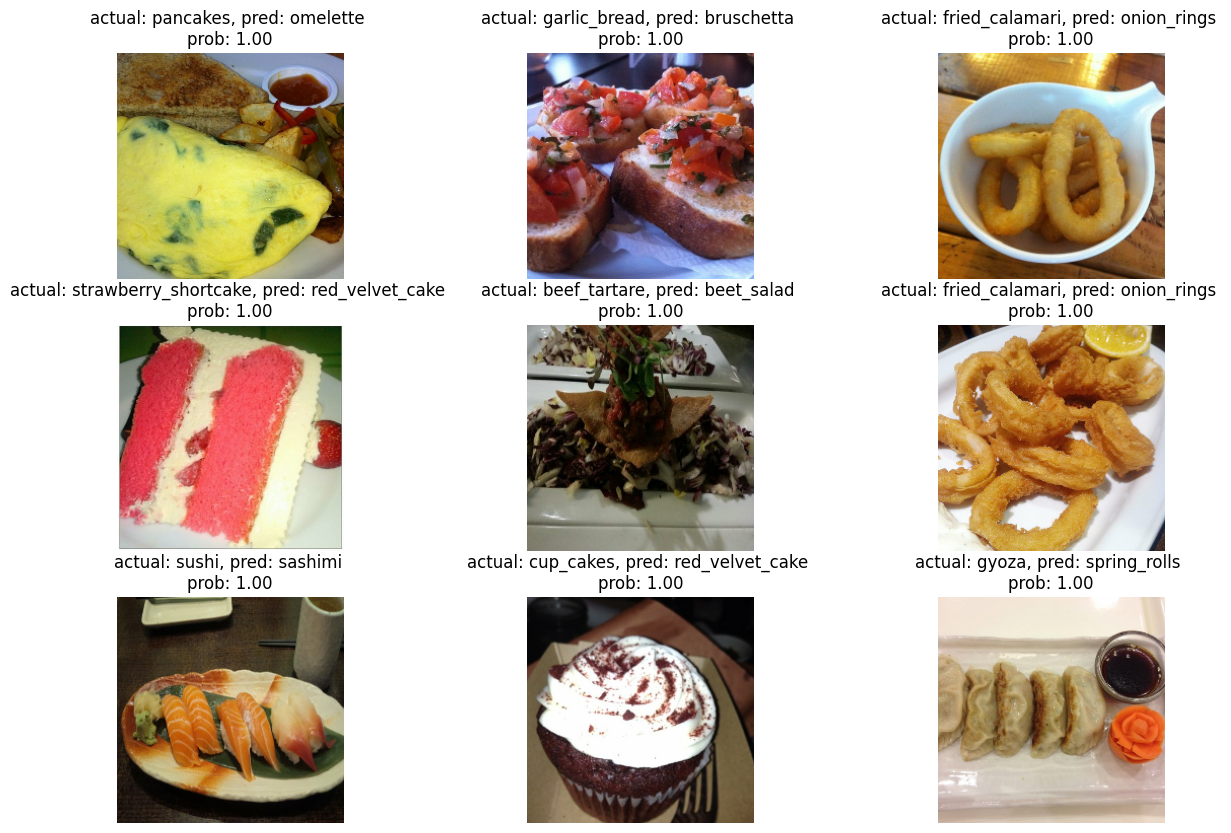

In [59]:
# Visualise
images_to_view = 9
start_index = 10 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

### Test out on custom images

In [60]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

/bin/bash: /home/ujjwal/miniconda3/envs/tf-nightly/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-08-22 23:31:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 2404:6800:4007:829::2010, 2404:6800:4007:82b::2010, 2404:6800:4007:828::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2404:6800:4007:829::2010|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  5.74MB/s    in 2.2s    

2023-08-22 23:31:59 (5.74 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [61]:
unzip_data("custom_food_images.zip")

In [62]:
os.listdir("custom_food_images")

['hamburger.jpeg',
 'sushi.jpeg',
 'ramen.jpeg',
 'pizza-dad.jpeg',
 'steak.jpeg',
 'chicken_wings.jpeg']

In [63]:
images = ["custom_food_images/"+i for i in os.listdir("custom_food_images")]
images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg']

1/1 [==============================] - 0s 141ms/step


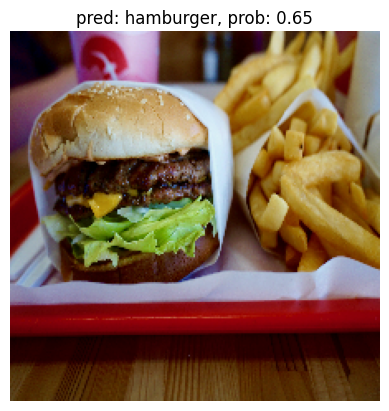

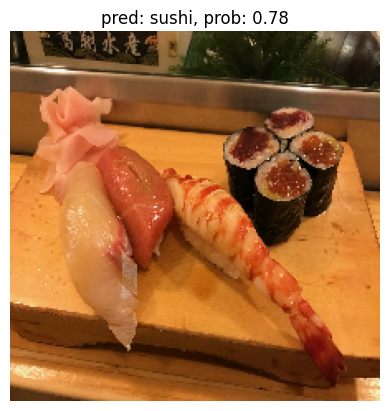

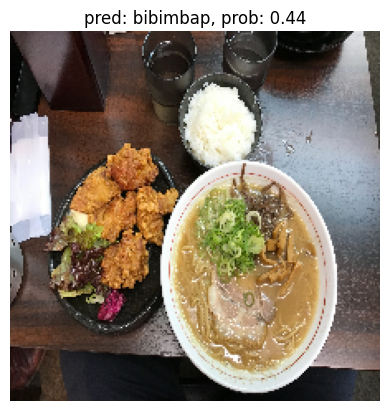

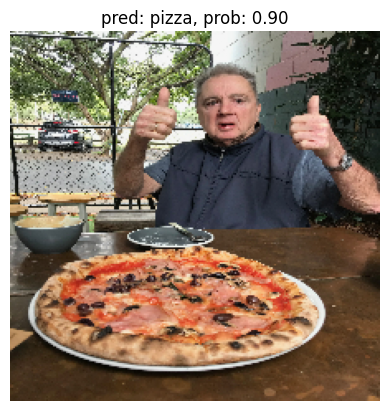

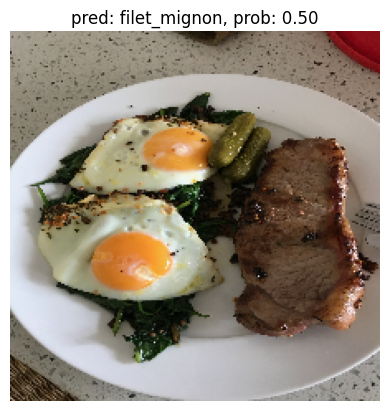

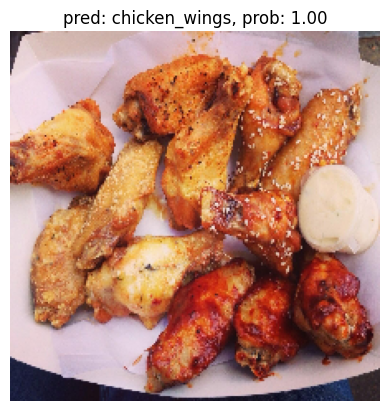

In [64]:
# Make predictions on images
for img in images:
  img = load_and_prep(img,scale=False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

# Exercise:
1. Take 3 of your own photos of food and use the trained model to make predictions on them, share your predictions with the other students in Discord and show off your Food Vision model 🍔👁.
2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
3. Recreate the first model (the feature extraction model) with mixed_precision turned on.
  * Does it make the model train faster?
  * Does it effect the accuracy or performance of our model?
  * What's the advantages of using mixed_precision training?

In [65]:
# 1. Take your own photos of food and use the trained model to make predictions on them
images=[]
for i in os.listdir("."):
  if ".jpg" in i:
    images.append("."+i)
print(images)
for img in images:
  img = load_and_prep(img,scale=False)
  pred_prob = model_1.predict(tf.expand_dims(img,axis=0))
  class_pred = class_names[tf.argmax(pred_prob[0])]
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

[]


In [66]:
# 2. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 epochs (like we've used in this notebook). Which method is better?
## Feature extraction for 10 epochs
print("Feature extraction (10)")
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=tf.keras.Input(shape=(224,224,3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(101,activation=tf.keras.activations.softmax)(x)
model_feature_extraction = tf.keras.Model(inputs,outputs)
model_feature_extraction.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=['accuracy'])
history_feature_extraction = model_feature_extraction.fit(train_data,
                                                          epochs=10,
                                                          steps_per_epoch=len(train_data),
                                                          validation_data=test_data,
                                                          validation_steps=int(0.15*len(test_data)),
                                                          verbose=1)

print("Feature extraction plus fine tuning (5+5)")
## Feature extraction plus fine tuning
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=tf.keras.Input(shape=(224,224,3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(101,activation=tf.keras.activations.softmax)(x)
model_feature_extraction_plus_fine = tf.keras.Model(inputs,outputs)
model_feature_extraction_plus_fine.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=['accuracy'])
history_feature_extraction_plus_fine = model_feature_extraction_plus_fine.fit(train_data,
                                                                              epochs=5,
                                                                              steps_per_epoch=len(train_data),
                                                                              validation_data=test_data,
                                                                              validation_steps=int(0.15*len(test_data)),
                                                                              verbose=1)
base_model.trainable=True
for layer in base_model.layers[:-10]:
  layer.trainable=False
model_feature_extraction_plus_fine.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                 metrics=['accuracy'])
history_feature_extraction_plus_fine = model_feature_extraction_plus_fine.fit(train_data,
                                                                              epochs=10,
                                                                              steps_per_epoch=len(train_data),
                                                                              validation_data=test_data,
                                                                              validation_steps=int(0.15*len(test_data)),
                                                                              verbose=1,
                                                                              initial_epoch=history_feature_extraction_plus_fine.epoch[-1])

x1 = (model_feature_extraction.evaluate(test_data))
x2 = model_feature_extraction_plus_fine.evaluate(test_data)
if x1[1]>x2[1]:
  print("Model with only feature extraction is better than fine tuning")
else:
  print("Model with both feature extraction and fine tuning performs better than just feature extraction")

Feature extraction (10)


Epoch 1/10
237/237 [==============================] - 22s 78ms/step - loss: 3.1371 - accuracy: 0.3320 - val_loss: 2.3177 - val_accuracy: 0.4791
Epoch 2/10
237/237 [==============================] - 18s 74ms/step - loss: 1.8303 - accuracy: 0.5931 - val_loss: 1.8781 - val_accuracy: 0.5410
Epoch 3/10
237/237 [==============================] - 18s 74ms/step - loss: 1.4324 - accuracy: 0.6671 - val_loss: 1.7437 - val_accuracy: 0.5506
Epoch 4/10
237/237 [==============================] - 18s 74ms/step - loss: 1.2014 - accuracy: 0.7222 - val_loss: 1.6573 - val_accuracy: 0.5675
Epoch 5/10
237/237 [==============================] - 18s 74ms/step - loss: 1.0307 - accuracy: 0.7675 - val_loss: 1.6218 - val_accuracy: 0.5731
Epoch 6/10
237/237 [==============================] - 18s 74ms/step - loss: 0.9073 - accuracy: 0.8022 - val_loss: 1.5727 - val_accuracy: 0.5869
Epoch 7/10
237/237 [==============================] - 18s 74ms/step - loss: 0.8037 - accuracy: 0.8283 - val_loss: 1.5620 - val_accuracy:

In [67]:
!nvidia-smi -L

/bin/bash: /home/ujjwal/miniconda3/envs/tf-nightly/lib/libtinfo.so.6: no version information available (required by /bin/bash)
GPU 0: NVIDIA GeForce RTX 3050 Laptop GPU (UUID: GPU-dfaf2dbb-aec7-1a43-9749-df5dc8fdb316)


In [68]:
# 3. Recreate the first model (the feature extraction model) with mixed_precision turned on.
from tensorflow import keras
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False
inputs=tf.keras.Input(shape=(224,224,3))
x = base_model(inputs)
# x = tf.keras.layers.Dense(40,activation=tf.keras.activations.relu)(inputs)
# x = tf.keras.layers.Conv2D(filters=25,kernel_size=3,activation=tf.keras.activations.relu)(x)
# x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs=tf.keras.layers.Dense(101,activation=tf.keras.activations.softmax,dtype=tf.float32)(x)
# outputs=tf.keras.layers.Activation('softmax', dtype='float32')(x)
model_feature_extraction = tf.keras.Model(inputs,outputs)
model_feature_extraction.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=['accuracy'])
history_feature_extraction = model_feature_extraction.fit(train_data,
                                                          epochs=10,
                                                          steps_per_epoch=len(train_data),
                                                          validation_data=test_data,
                                                          validation_steps=int(0.15*len(test_data)),
                                                          verbose=1)

Compute dtype: float16
Variable dtype: float32


Epoch 1/10
237/237 [==============================] - 22s 79ms/step - loss: 3.1315 - accuracy: 0.3360 - val_loss: 2.2564 - val_accuracy: 0.5072
Epoch 2/10
237/237 [==============================] - 18s 75ms/step - loss: 1.8313 - accuracy: 0.5819 - val_loss: 1.8488 - val_accuracy: 0.5524
Epoch 3/10
237/237 [==============================] - 18s 75ms/step - loss: 1.4372 - accuracy: 0.6653 - val_loss: 1.7394 - val_accuracy: 0.5591
Epoch 4/10
237/237 [==============================] - 19s 79ms/step - loss: 1.2080 - accuracy: 0.7166 - val_loss: 1.6662 - val_accuracy: 0.5691
Epoch 5/10
237/237 [==============================] - 19s 80ms/step - loss: 1.0366 - accuracy: 0.7649 - val_loss: 1.6148 - val_accuracy: 0.5768
Epoch 6/10
237/237 [==============================] - 20s 86ms/step - loss: 0.9105 - accuracy: 0.7987 - val_loss: 1.5829 - val_accuracy: 0.5808
Epoch 7/10
237/237 [==============================] - 19s 81ms/step - loss: 0.7998 - accuracy: 0.8286 - val_loss: 1.5547 - val_accuracy:

* The training time for each epoch is faster when using mixed precision
* The performance has taken a hit
* Advantages of using mixed precison is that the training time is faster on Nvidia GPU's, it uses lesser number of bits to perform calculation while maintaining full length of bits for varibales